In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")

# CHAPTER 15. 오토 인코더

오토인코더(autoencoder)는 어떤 감독 없이도 입력 데이터의 효율적인표현인 코딩(coding)을 학습할 수 있는 인공 신경망이다.

이러한 코딩은 일반적으로 입력보다 훨씬 낮은 차원을 가진다. -> 차원 축소에 유용하게 사용한다.

더 중요한 점은 오토인코더가 강력한 특성 추출기처럼 작동하기 때문에 심층 신경망의 비지도 사전훈련에 사용될 수 있다.

또한 훈련 데이터와 매우 비슷한 새로운 데이터를 생성할 수 있다. - 생성 모델(Generative model)

ex) 얼굴 사진을 사용해 오토인코더를 훈련시키면 이 모델은 새로운 얼굴을 생성할 수 있다. (GAN처럼)

오토인코더가 학습하는 것은 단순히 입력을 출력으로 복사하는 것이다.

네트워크에 여러 방법으로 제약(Constraint)을 가해 어려운 작업으로 만든다.

예로서,

Constraint autoencoder - 내부 표현의 크기를 제한하거나(은닉층에 있는 뉴런 수를 입력층보다 적게한다)

Denoising autoencoder - 입력에 잡음을 추가한 후 원본 입력을 복원할 수 있도록 네트워크를 훈련시킨다

이러한 제약은 오토인코더가 단순히 입력을 바로 출력으로 복사하지 못하도록 막고, 
데이터를 효율적으로 표현하는 방법을 배우도록 강제시킨다.

간단히 말해서, 코딩은 어떤 제약 조건 하에서 항등 함수를 학습하려는 오토인코더의 노력으로 생겨난 부산물이다.


## 추가 설명|
참조 : 오토인코더의 모든것

link : https://www.youtube.com/watch?v=o_peo6U7IRM&t=5147s


위키피디아에서의 Autoencoder

Keywords
- Unsupervised learning(Self-learning)

- Nonlinear Dimensionality reduction(Manifold learning)
   
- Generative model learning

- Maximum Likelihood density estimation

<center><img src="./images/15-1/15-1.png" width="80%" height="80%"></center>  <br>


## 차원의 저주

데이터의 차원이 증가할수록 각 영역에 포함되는 데이터의 개수

<center><img src="./images/15-1/15-2.png" width="80%" height="80%"></center>  <br>

데이터의 차원이 증가할수록 해당 공간의 크기(부피)가 기하급수적으로 증가하기 때문에,

동일한 개수의 데이터 밀도는 차원이 증가할수록 급속도로 희박해진다.

따라서, 차원이 증가할수록 데이터의 분포 분석 또는 모델 추정에 필요한 샘플 데이터 개수가 기하급수적으로 증가하게 된다.

## 차원을 축소하는 방법

- 투영(projection)

- 매니폴드 학습(Manifold Learning)

## 투영(projection)

실제 훈련 샘플은 모든 차원에 걸쳐 균일하게 퍼져 있지 않는다.

많은 특성은 거의 변화가 없는 반면, 다른 특성들은 서로 강하게 연관되어 있다.

결과적으로 모든 훈련 샘플이 사실 고차원 공간 안의 저차원 부분 공간(subspace)에 놓여 있다.

<center><img src="./images/15-1/15-3.png" width="80%" height="80%"></center>  <br>


하지만, 차원 축소에 있어서 투영이 최선의 방법은 아니다.

<center><img src="./images/15-1/15-4.png" width="80%" height="80%"></center>  <br>

다음의 스위스 롤 데이터셋처럼 부분 공간이 뒤틀리거나 휘어 있기도 하다.

그냥 평면에 투영시키게 되면, 스위스 롤의 층이 서로 뭉개진다. -> 우리가 원하는 것은 Projection 결과가 아니다.


## Manifold

위의 스위스 롤은 2D 매니폴드의 한 예이다.

간단히 말해 2D 매니폴드는 고차원 공간에서 휘어지거나 뒤틀린 2D 모양이다.

Manifold란 국소적으로 유클리드 공간과 닮은 위상 공간으로 정의된다.

d차원 매니폴드는 국부적으로 d차원 초평면으로 보일 수 있는 n차원 공간의 일부이다.(d < n)

Manifold learning은 많은 차원 축소 알고리즘이 훈련 샘플이 놓여 있는 매니폴드를 모델링하는 방식으로 동작한다.

이는 대부분 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있다는 매니폴드 가정 또는 매니폴드 가설에 근거한다.

## Manifold assumption or Hypothesis(매니폴드 가정 또는 가설)

MNIST 데이터셋으로 생각해보면,

전체 손글씨 숫자 이미지는 어느 정도 비슷한 면이 존재한다.

선으로 연결되어 있고 경계는 흰색이고 어느 정도 중앙에 있다.

숫자 이미지를 만들 때 가능한 자유도는 아무 이미지나 생성할 때의 자유도보다 훨씬 낮다.

이런 제약은 데이터셋을 저차원의 매니폴드로 압축할 수 있도록 도와준다.


200 * 200 RGB 이미지는 10^96329의 가능한 상태들이 존재한다.

숫자, 얼굴 등에 대한 이미지 샘플들은 어딘가에 모여있지 않을까??

<center><img src="./images/15-1/15-5.png" width="80%" height="80%"></center>  <br>


Manifold 학습의 목적

- 데이터 압축

- 데이터 시각화

- 차원의 저주 피하기

- 유용한 특징(feature) 추출

---
## 15.1 효율적인 데이터 표현

숙련된 체스 플레이어가 체스 판을 5초 동안만 바라보고도 전체 말의 위치를 외울 수 있다.

그러나 이는 체스 말들이 무작위로 놓여 있을 때가 아니라 현실적인 위치에 있을 경우에만 가능하다.
(게임에 대한 경험 덕분에 체스 패턴을 더 쉽게 본다.)

-> 패턴을 찾으면 정보를 효율적으로 저장할 수 있다.

이러한 체스 플레이어 실험처럼 ,

오토인코더는 입력을 받아 효율적인 내부 표현(representation)으로 바꾸고 입력과 매우 가까워 보이는 어떤 것을 출력한다.

오토인코더는 입력을 내부 표현으로 바꾸는 인코더(encoder)와 내부 표현을 출력으로 바꾸는 디코더(decoder)로 구성된다.


<center><img src="./images/15-1/15-6.png" width="80%" height="80%"></center>  <br>


출력층의 뉴런 수가 입력 개수와 동일하다는 것을 제외하면, 일반적으로 오토인코더는 다층 퍼셉트론(MLP)과 동일한 구조이다.

비용 함수(Loss Function)은 재구성이 입력과 다를 때 모델에 벌점을 부과하는 재구성 손실(reconstruction error)를 포함한다.

내부 표현이 입력 데이터보다 저차원이기 때문에(3차원->2차원)

이러한 오토인코더를 과소완전(undercomplete)라고 한다.

*undercomplete의 수학적 정의 - 기저(basis)보다 적은 개수로 표현되는 것

과소완전 오토인코더는 입력을 코딩으로 간단히 복사할 수 없으며,

입력과 똑같은 것을 출력하기 위해 중요한 특성(feature)를 학습하도록 만든다.

## 15.2 과소완전 선형 오토인코더로 PCA 수행하기

오토인코더가 선형 활성화 함수만 사용하고 비용 함수가 평균 제곱 오차(MSE)라면,

이는 결국 주성분 분석을 수행하는 것으로 볼 수 있다.

* 주성분 분석(PCA, Principal Component Analysis)은 가장 대표적인 차원 축소 알고리즘이다.

PCA는 먼저 데이터에 가장 가까운 초평면(hyperplane)을 구한 다음, 데이터를 이 초평면에 투영(projection)시킨다.

<center><img src="./images/15-1/15-7.png" width="80%" height="80%"></center>  <br>

PCA의 단계
 1. 학습 데이터셋에서 분산이 최대인 축을 찾는다.
 
 2. 이렇게 찾은 첫번째 축가 직교하면서 분산이 최대인 두 번째 축을 찾는다.
 
 3. 첫 번째 축과 두 번째 축에 직교하고 분산을 최대한 보존하는 세 번째 축을 찾는다.
 
 4. 1~3과 같은 방법으로 데이터셋의 차원만큼의 축을 찾는다.
 
 - i 번째 축을 정의하는 단위 백터를 주성분(principal Component)라고 부른다.

다음 코드는 3D 데이터셋에 PCA를 적용해 2D에 투영하는 간단한 선형 오토인코더를 만든다.

## 임의의 데이터셋 생성

In [2]:
# 3D 데이터셋을 만듦
import numpy.random as rnd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

# numpy를 이용하여 랜덤 데이터셋 생성
angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [3]:
# 데이터 정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

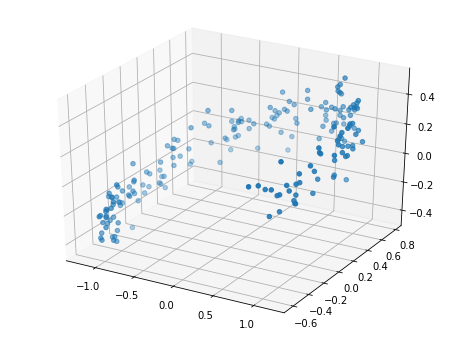

In [4]:
# 3D 데이터 셋 시각화
fig = plt.figure(figsize=[8,6])
ax = plt.axes(projection='3d')
ax.scatter3D(data[:,0], data[:,1], data[:,2]);

## 오토인코더로 PCA 수행

In [5]:

import tensorflow as tf

n_inputs = 3  # 3D 입력
n_hidden = 2  # 2D 코딩
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)                         # 기본적으로 linear activation function
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))  # Mean Square Error

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


해당 코드는 이전 장에서 만들었던 MLP와 정말로 비슷하다.

특별히 언급할 두 가지는 다음과 같다.

- 출력의 개수가 입력의 개수와 동일하다.

- 단순한 PCA를 수행하기 위해서는 활성화 함수를 사용하지 않으며(즉, 모든 뉴런이 선형이다.),
  비용 함수는 MSE다.
  

In [6]:
n_iterations = 1000

codings = hidden #코딩을 만드는 은닉층을 출력한다.

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})   # 레이블이 없다(비지도 학습).
    codings_val = codings.eval(feed_dict={X: X_test})

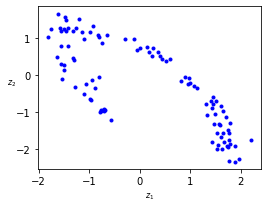

In [7]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=8)
plt.ylabel("$z_2$", fontsize=8, rotation=0)
plt.show()

## sklearn의 PCA 모델을 사용한 동일 3D 데이터셋 2차원으로 줄이기

In [8]:
# sklearn의 PCA 모델 사용을 위함
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # 2차원으로 줄이기 위함
x_new = pca.fit_transform(data)

In [9]:
print('singular value :', pca.singular_values_)
print('singular vector :\n', pca.components_.T)

singular value : [12.85874036  4.97727263]
singular vector :
 [[-0.9344126   0.34091963]
 [-0.30058427 -0.91014756]
 [-0.19110781 -0.23538314]]


In [10]:
print('eigen_value :', pca.explained_variance_)
print('explained variance ratio :', pca.explained_variance_ratio_)

eigen_value : [0.83089047 0.12448866]
explained variance ratio : [0.8618954  0.12913399]


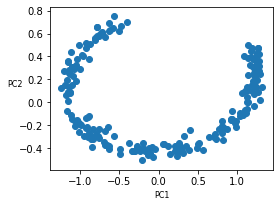

In [11]:
fig = plt.figure(figsize=(4,3))
plt.scatter(x_new[:,0], x_new[:,1])
#plt.plot(x_new[:,0], x_new[:,1])

#plt.plot(pca_val[:,0], pca_val[:, 1], "b.")
plt.xlabel('PC1', fontsize=8)
plt.ylabel('PC2', fontsize=8, rotation=0)
plt.show()





## MNIST 데이터를 활용한 PCA와 오토인코더 비교

MNIST 학습을 위해 적층 오토인코더로 구현(적층 오토인코더는 이후 설명 예정)

In [12]:
%matplotlib notebook
import pylab as plt
import numpy as np
import seaborn as sns; sns.set()

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)

# 데이터 셋 0-255 -> 0-1로 normalization
x_train = x_train.reshape(60000, 784) / 255
x_test = x_test.reshape(10000, 784) / 255

print(x_train.shape)

Using TensorFlow backend.


(60000, 28, 28)
(60000, 784)


## PCA

In [13]:
mu = x_train.mean(axis=0)
# SVD(Singular Value Decomposition)로 Training set 분해 후 V값 가져옴
# V 값이 주성분에 해당함
# numpy의 svd 함수 이용
U,s,V = np.linalg.svd(x_train - mu, full_matrices=False)
Zpca = np.dot(x_train - mu, V.transpose())

Rpca = np.dot(Zpca[:,:2], V[:2,:]) + mu    # 재구성

In [14]:
# sklearn의 PCA 모델 사용(SVD 분해 방법 사용하여 구현됨)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)   # principal component 2
reduced_data_pca = pca.fit_transform(x_train)

## autoencoder

In [15]:
m = Sequential()
m.add(Dense(512,  activation='elu', input_shape=(784,)))   # 784 - 512 - 128 - 2 - 128 - 512 - 784 Neural Network 구성
m.add(Dense(128,  activation='elu'))
m.add(Dense(2,    activation='linear', name="bottleneck")) # bottleneck hidden layer
m.add(Dense(128,  activation='elu'))
m.add(Dense(512,  activation='elu'))
m.add(Dense(784,  activation='sigmoid'))

m.compile(loss='mean_squared_error', optimizer = Adam())

history = m.fit(x_train, x_train, batch_size=128, epochs=5, verbose=1, validation_data=(x_test, x_test))

encoder = Model(m.input, m.get_layer('bottleneck').output) #인코더, 입력을 내부표현으로
Zenc = encoder.predict(x_train)  # bottleneck representation
Renc = m.predict(x_train)        # reconstruction

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 14s 232us/step - loss: 0.0579 - val_loss: 0.0486
Epoch 2/5
60000/60000 [==============================] - 14s 229us/step - loss: 0.0467 - val_loss: 0.0447
Epoch 3/5
60000/60000 [==============================] - 14s 231us/step - loss: 0.0439 - val_loss: 0.0427
Epoch 4/5
60000/60000 [==============================] - 12s 193us/step - loss: 0.0421 - val_loss: 0.0411
Epoch 5/5
60000/60000 [==============================] - 13s 213us/step - loss: 0.0407 - val_loss: 0.0399


In [16]:
m = Sequential()
m.add(Dense(2,  activation='elu', input_shape=(784,)))
m.add(Dense(2,    activation='linear', name="bottleneck"))
m.add(Dense(784,  activation='sigmoid'))
m.compile(loss='mean_squared_error', optimizer = Adam())
history = m.fit(x_train, x_train, batch_size=128, epochs=5, verbose=1, 
                validation_data=(x_test, x_test))

encoder = Model(m.input, m.get_layer('bottleneck').output)
Zenc = encoder.predict(x_train)  # bottleneck representation
Renc = m.predict(x_train)        # reconstruction

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 2s 29us/step - loss: 0.0874 - val_loss: 0.0661
Epoch 2/5
60000/60000 [==============================] - 1s 23us/step - loss: 0.0636 - val_loss: 0.0622
Epoch 3/5
60000/60000 [==============================] - 1s 23us/step - loss: 0.0616 - val_loss: 0.0609
Epoch 4/5
60000/60000 [==============================] - 1s 23us/step - loss: 0.0606 - val_loss: 0.0600
Epoch 5/5
60000/60000 [==============================] - 1s 23us/step - loss: 0.0598 - val_loss: 0.0593


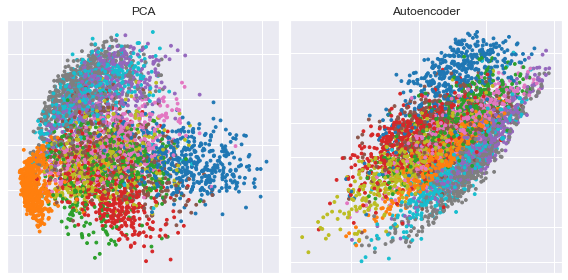

In [58]:
#PCA로 차원 축소 후의 데이터 셋 plot 
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('PCA')
#plt.scatter(Zpca[:5000,0], Zpca[:5000,1], c=y_train[:5000], s=8, cmap='tab10')
plt.scatter(reduced_data_pca[:5000,0], reduced_data_pca[:5000,1], c=y_train[:5000], s=8, cmap='tab10')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])


#인코더 활용 데이터 셋 plot
plt.subplot(122)
plt.title('Autoencoder')
plt.scatter(Zenc[:5000,0], Zenc[:5000,1], c=y_train[:5000], s=8, cmap='tab10')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

plt.tight_layout()

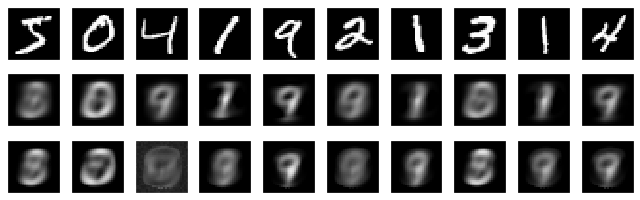

In [59]:
plt.figure(figsize=(9,3))
# 원본과 재구성(PCA/autoencoder)한 데이터 비교
toPlot = (x_train, Rpca, Renc)
for i in range(10):
    for j in range(3):
        ax = plt.subplot(3, 10, 10*j+i+1)
        plt.imshow(toPlot[j][i,:].reshape(28,28), interpolation="nearest", 
                   vmin=0, vmax=1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.tight_layout()

MSE로 loss를 구하는데, 이미지를 보면 원본 이미지와 숫자 영역 외 부분에 대해서

x-x'이므로, 평균을 내면 거의 대부분이 0이다.

즉 결과물이 좋지 않아도 loss가 1 아래로 나올 가능성이 높음

따라서 autoencoder에서 node 수를 줄이더라도 loss가 생각보다 적게 나올 수 있다.

In [19]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min()  # make the minimum == 0, so the padding looks white
    w,h = images.shape[1:]
    image = np.zeros(((w+pad)*n_rows+pad, (h+pad)*n_cols+pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),(x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")
    
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

---
## 15.3 적층 오토인코더

> * 다른 신경망과 마찬가지로 오토인코더도 여러 개의 은닉층을 가질 수 있다. 이런 경우를 적층 오토인코더(stacked autoencorder) 또는 심층 오토인코더(deep autoencoder)라고 한다.
> + 층을 더 추가하면 오토인코더가 더 복잡한 코딩을 학습할 수 있다. 하지만, 오토인코더가 너무 강력하게 되지 않도록 주의해야한다. 
> * 3 개의 히든 레이어와 1 개의 출력 레이어로 구성된 적층 오토인코더를 한다. ELU 활성화, He 초기화 및 L2 정규화를 사용한다.

In [20]:
import tensorflow as tf
import time
print(tf.__version__)

1.13.1


In [21]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting tmp/data/train-labels-idx1-ubyte.gz
Extracting tmp/data/t10k-images-idx3-ubyte.gz
Extracting tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


file:///home/lsgx/Pictures/Screenshot%20from%202019-05-31%2013-38-13.png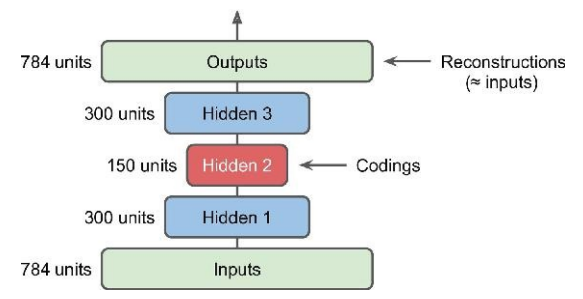

In [22]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
#Equivalent to:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

'''
n_hidden_a = 250
n_hidden_b = 200
n_hidden_c = 175
n_hidden_d = n_hidden_c
n_hidden_e = n_hidden_b
n_hidden_f = n_hidden_a

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden_a)
hidden3 = my_dense_layer(hidden2, n_hidden_b)
hidden4 = my_dense_layer(hidden3, n_hidden_c)
hidden5 = my_dense_layer(hidden4, n_hidden2)
hidden6 = my_dense_layer(hidden5, n_hidden_d)
hidden7 = my_dense_layer(hidden6, n_hidden_e)
hidden8 = my_dense_layer(hidden7, n_hidden_f)
hidden9 = my_dense_layer(hidden8, n_hidden3)
outputs = my_dense_layer(hidden9, n_outputs, activation=None)
'''
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # not shown in the book

> * 숫자 레이블 (y_batch)를 사용하지 않는다.

In [60]:
n_epochs = 5
batch_size = 150

start_time = time.time() 
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./saveModels/autoencoder_my_model_all_layers.ckpt")

print("--- %s seconds ---" %(time.time() - start_time))

09% Train MSE: 0.02610345
19% Train MSE: 0.023838291
29% Train MSE: 0.021653065
39% Train MSE: 0.021828514
49% Train MSE: 0.02134504
--- 24.95668888092041 seconds ---


> * 결과 확인

In [24]:
def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt
Saving figure reconstruction_plot


<Figure size 432x288 with 0 Axes>

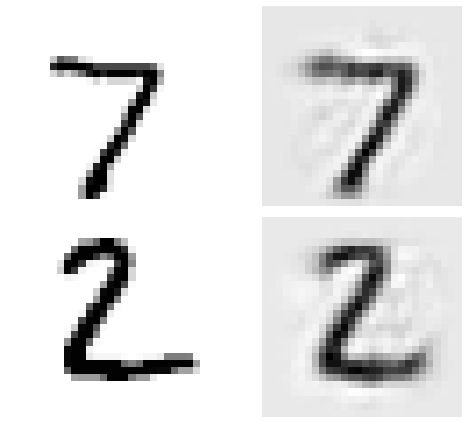

In [25]:
plt.clf()
show_reconstructed_digits(X, outputs, "./saveModels/autoencoder_my_model_all_layers.ckpt")
save_fig("reconstruction_plot")

> * 가중치 묶기
>   - 위와 같이 오토인코더의 구조가 완벽하게 대칭일 때 일반적으로 디코더의 가중치와 인코더의 가중치를 묶는다. 이렇게 함으로써 훈련 속도를 줄일 수 있고, 과대적합을 피할 수 있다.
>   - 불행히도 일반적으로 사용하는 dense()함수를 이용해 가중치를 묶으려면 상당히 복잡해진다. 그래서 직접 층을 정의하여 사용한다.

In [26]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs


learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])



weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

'''

n_hidden_a = 299
n_hidden_b = 298
n_hidden_c = 297
n_hidden_d = n_hidden_c
n_hidden_e = n_hidden_b
n_hidden_f = n_hidden_a

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden_a])
weights3_init = initializer([n_hidden_a, n_hidden_b])
weights4_init = initializer([n_hidden_b, n_hidden_c])
weights5_init = initializer([n_hidden_c, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")
weights5 = tf.Variable(weights5_init, dtype=tf.float32, name="weights5")
weights6 = tf.transpose(weights5, name="weights6")  # tied weights
weights7 = tf.transpose(weights4, name="weights7")  # tied weights
weights8 = tf.transpose(weights3, name="weights8")  # tied weights
weights9 = tf.transpose(weights2, name="weights9")  # tied weights
weights10 = tf.transpose(weights1, name="weights10")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases_a = tf.Variable(tf.zeros(n_hidden_a), name="biases_a")
biases_b = tf.Variable(tf.zeros(n_hidden_b), name="biases_b")
biases_c = tf.Variable(tf.zeros(n_hidden_c), name="biases_c")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases_d = tf.Variable(tf.zeros(n_hidden_d), name="biases_d")
biases_e = tf.Variable(tf.zeros(n_hidden_e), name="biases_e")
biases_f = tf.Variable(tf.zeros(n_hidden_f), name="biases_f")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden_a = activation(tf.matmul(hidden1, weights2) + biases_a)
hidden_b = activation(tf.matmul(hidden_a, weights3) + biases_b)
hidden_c = activation(tf.matmul(hidden_b, weights4) + biases_c)
hidden2 = activation(tf.matmul(hidden_c, weights5) + biases2)
hidden_d = activation(tf.matmul(hidden2, weights6) + biases_d)
hidden_e = activation(tf.matmul(hidden_d, weights7) + biases_e)
hidden_f = activation(tf.matmul(hidden_e, weights8) + biases_f)
hidden3 = activation(tf.matmul(hidden_f, weights9) + biases3)
outputs = tf.matmul(hidden3, weights10) + biases4
'''

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()



In [27]:
n_epochs = 5
batch_size = 150

start_time = time.time() 
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./saveModels/autoencoder_my_model_tying_weights.ckpt")

print("--- %s seconds ---" %(time.time() - start_time))

09% Train MSE: 0.01506695
19% Train MSE: 0.016488738
29% Train MSE: 0.017375927
39% Train MSE: 0.016878325
49% Train MSE: 0.015587717
--- 23.228593826293945 seconds ---


INFO:tensorflow:Restoring parameters from ./saveModels/autoencoder_my_model_tying_weights.ckpt


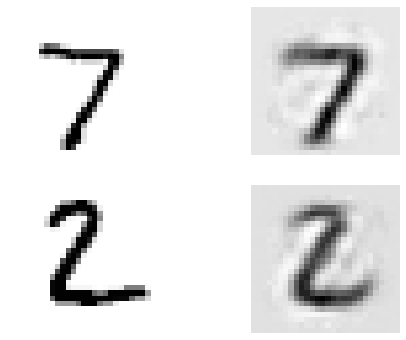

In [28]:
show_reconstructed_digits(X, outputs, "./saveModels/autoencoder_my_model_tying_weights.ckpt")

> * 한번에 한 층씩 훈련하기
>   - 오토인코더를 구성하는 모든 층을 한번에 훈련 시키는 것 보다 한층씩 훈련시키고 그것들을 쌓아올려서 만드는 방법이 훨씬 빠르게 수렴한다.

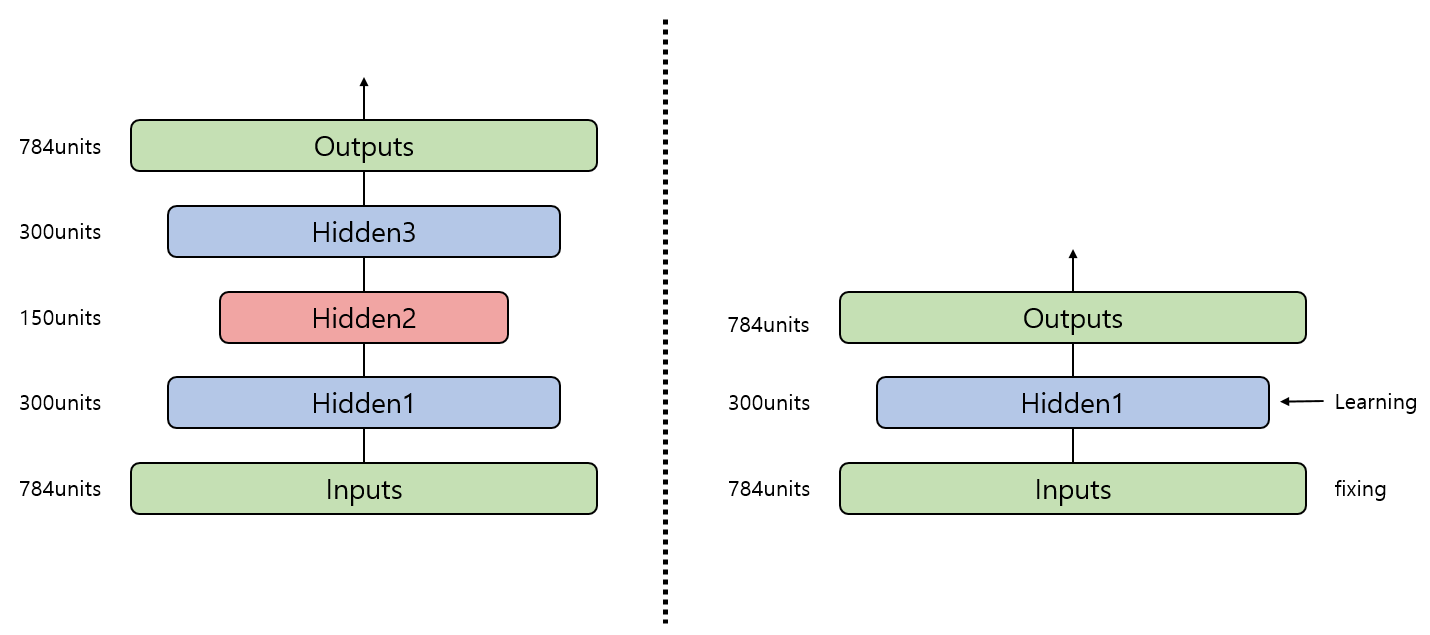
* 첫 번째 입력층을 재구성하는 오토인코더를 제작
* 그림과 같이 3계층의 오토인코더를 훈련하여 학습된 Hidden1을 얻는다.

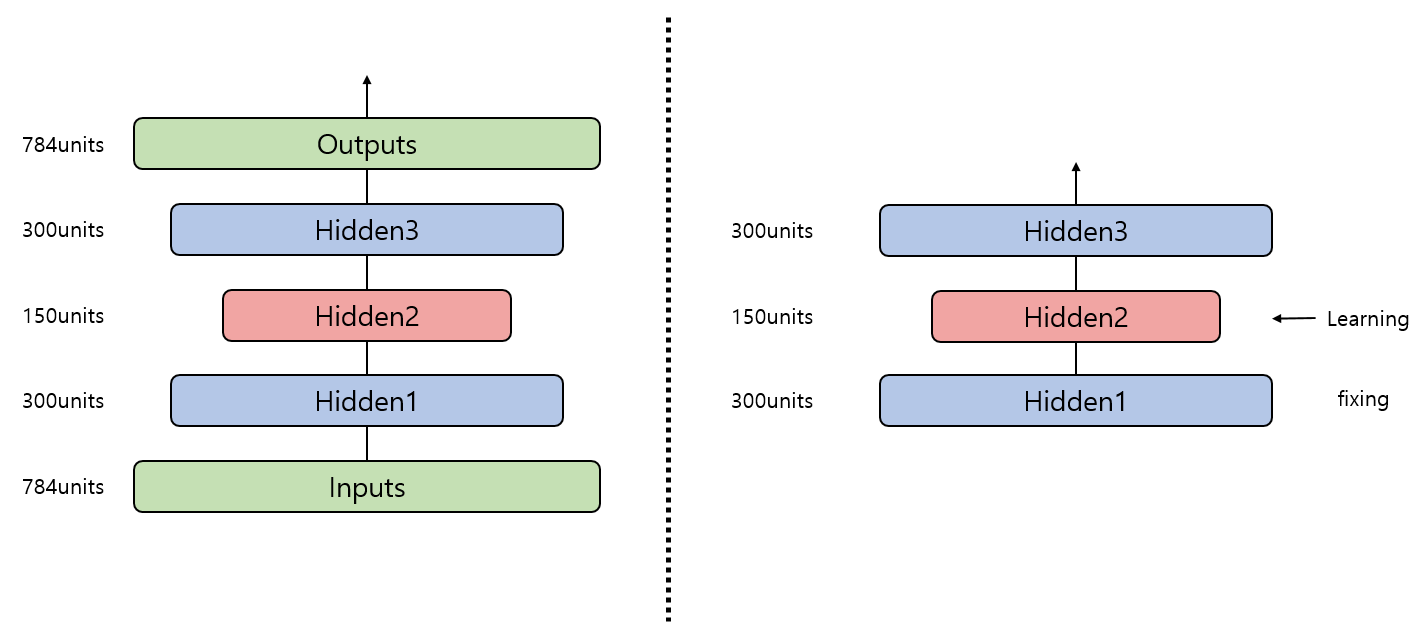
* 다음 층의 학습을 위해 첫 번째 훈련에서 학습된 Hidden1을 고정하고, Hidden1을 재구성하기 위한 Hidden2의 학습을 진행한다.  

In [29]:
reset_graph()

#특정 함수의 파라미터를 고정하여 여러개 만들 수 있음
from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005, seed=42,
                      hidden_activation=tf.nn.elu,
                      output_activation=tf.nn.elu):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, activation=hidden_activation, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=output_activation, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        
        #hidden_val : 학습한 층에 입력값을 통과하고 나오는 값
        #params["hidden/kernel:0"]  : 첫 번째 은닉층의 가중치
        #params["hidden/bias:0"]    : 첫 번째 은닉층의 편향
        #params["outputs/kernel:0"] : 두 번째 은닉층의 가중치
        #params["outputs/bias:0"]   : 두 번째 은닉층의 편향
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [30]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, n_neurons=300, n_epochs=4, batch_size=150,
                                                  output_activation=None)
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, n_epochs=4, batch_size=150)

09% Train MSE: 0.018517934
19% Train MSE: 0.018682716
29% Train MSE: 0.018467715
39% Train MSE: 0.019231727
09% Train MSE: 0.0042361096
1 Train MSE: 0.004832683
29% Train MSE: 0.0046687485
3 Train MSE: 0.00440391


In [31]:
reset_graph()

n_inputs = 28*28

#위의 학습해둔 가중치와 바이어스 그대로 사용
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.matmul(hidden3, W4) + b4

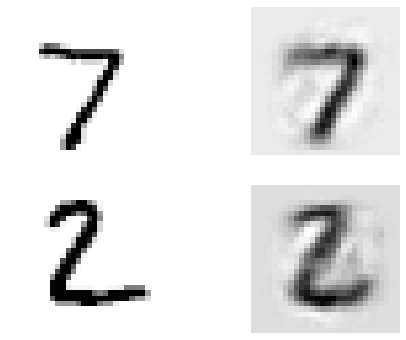

In [32]:
show_reconstructed_digits(X, outputs)

> * 분할하여 학습하지 않고 하나의 그래프로 학습하는 법
> * 내부적으로 첫 번째 은닉층을 학습하는 단계와 두번째 은닉층을 학습하는 단계로 나눈다.

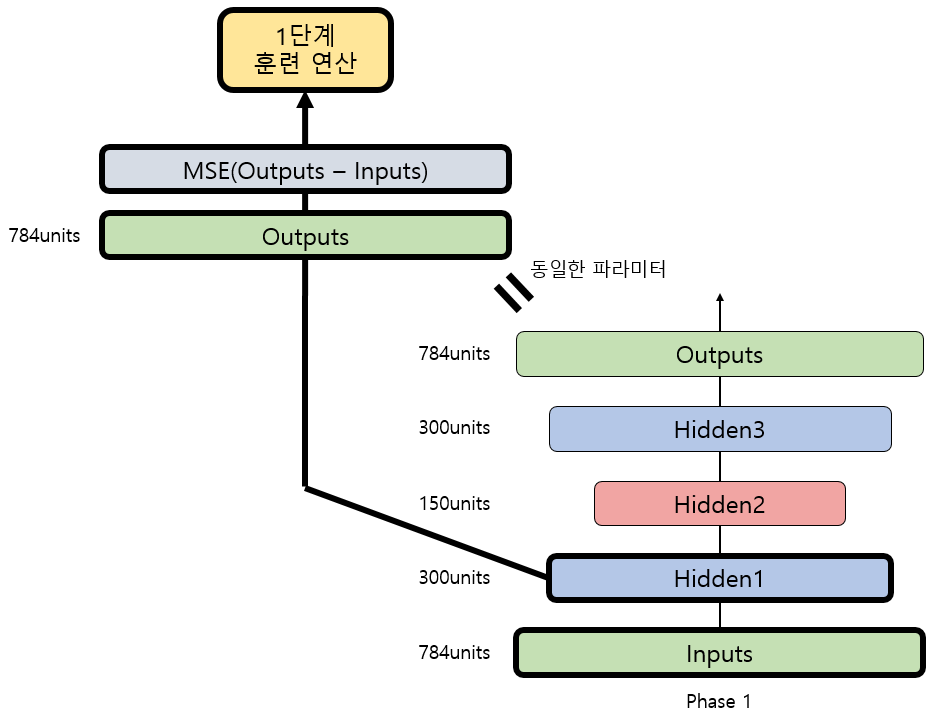
> * 첫 번째 페이즈

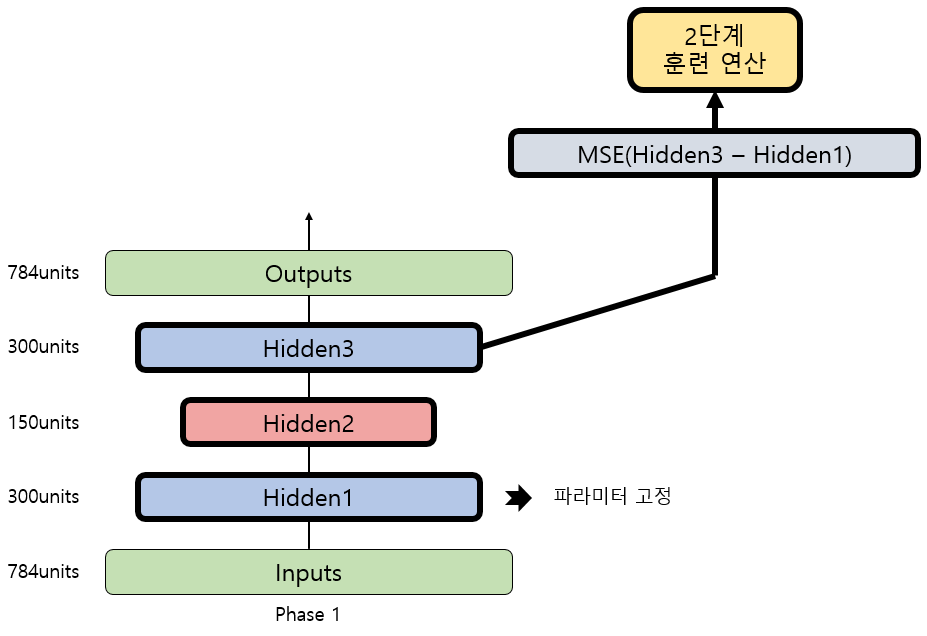
> * 두 번째 페이즈

In [33]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [34]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3 히든 1에서 바로 4로 넘어감
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1

In [35]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [36]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./saveModels/autoencoder_my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)


Training phase #1
09% Train MSE: 0.0074068652
19% Train MSE: 0.007828818
29% Train MSE: 0.007728095
39% Train MSE: 0.0074090054
Training phase #2
09% Train MSE: 0.3257826
19% Train MSE: 0.005739537
2 Train MSE: 0.0029418443
3 Train MSE: 0.0024437667
Test MSE: 0.009802574


> 단계 1에서는 은닉층 1을 학습한다. 단계 2에서는 은닉층 1은 학습되지 않고 동결되기 때문에 단계 1에서 학습이 완료된 은닉층 1을 저장하여 그대로 사용하면 학습 속도가 빨라진다

In [37]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./saveModels/autoencoder_my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
09% Train MSE: 0.007538258
1 Train MSE: 0.0077546984
29% Train MSE: 0.0073436773
39% Train MSE: 0.007837773
Training phase #2
0 Train MSE: 0.16884099
1 Train MSE: 0.0044883136
29% Train MSE: 0.002480846
39% Train MSE: 0.002030087
Test MSE: 0.00977958


> * 재구성 시각화

INFO:tensorflow:Restoring parameters from ./saveModels/autoencoder_my_model_one_at_a_time.ckpt


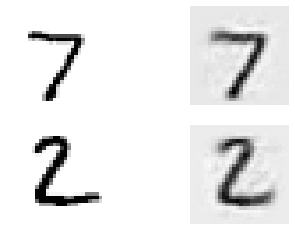

In [38]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./saveModels/autoencoder_my_model_one_at_a_time.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

> * 특성 시각화

INFO:tensorflow:Restoring parameters from ./saveModels/autoencoder_my_model_one_at_a_time.ckpt
Saving figure extracted_features_plot


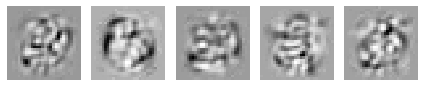

In [39]:
with tf.Session() as sess:
    saver.restore(sess, "./saveModels/autoencoder_my_model_one_at_a_time.ckpt") # not shown in the book
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

save_fig("extracted_features_plot") # not shown
plt.show()                          # not shown

---
## 15.4 비지도 사전학습

> * 오토인코더가 잘 훈련되었다는 뜻은 가지고있는 데이터셋들의 특징을 잘 파악했다는 것을 의미한다.
> * 이러한 특성을 이용해 라벨링된 데이터셋을 오토인코더로 미리 훈련을 시켜놓고 그 하위층들을 분류기에 그대로 활용하면 빠른 학습 수렴 속도를 가질 것으로 예상됨

> * 일반 DNN을 이용한 훈련

In [40]:
reset_graph()

#DNN
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_outputs), name="biases3")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
logits = tf.matmul(hidden2, weights3) + biases3

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
reg_loss = regularizer(weights1) + regularizer(weights2) + regularizer(weights3)
loss = cross_entropy + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

In [41]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end=" ")
        saver.save(sess, "./saveModels/autoencoder_my_model_supervised.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

09% Train accuracy: 0.97333336 Test accuracy: 0.9334
1 Train accuracy: 0.98 Test accuracy: 0.9361
29% Train accuracy: 0.97333336 Test accuracy: 0.9382
3 Train accuracy: 0.9866667 Test accuracy: 0.9493


> * 오토인코더를 이용한 사전학습

In [42]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

#training_op = optimizer.minimize(loss, var_list=[weights3, biases3])  # Freeze layers 1 and 2 (optional)

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./saveModels/autoencoder_my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./saveModels/autoencoder_my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

INFO:tensorflow:Restoring parameters from ./my_model_cache_frozen.ckpt
09% Train accuracy: 0.96	Test accuracy: 0.9366
19% Train accuracy: 0.99333334	Test accuracy: 0.9434
2 Train accuracy: 0.98	Test accuracy: 0.9462
3 Train accuracy: 0.98	Test accuracy: 0.9457


---
## 15.5 잡음제거 오토인코더

> * 입력에 잡음을 추가하고 출력에 잡음이 없는 원본 입력을 복구하도록 훈련시키는 것

> * 가우시안 잡음을 이용한 잡음제거 오토인코더

In [43]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [44]:
noise_level = 0.1

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [45]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [46]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./saveModels/autoencoder_my_model_stacked_denoising_gaussian.ckpt")

0 Train MSE: 0.02484258
19% Train MSE: 0.023446651
29% Train MSE: 0.022992296
39% Train MSE: 0.022206126
49% Train MSE: 0.021310458
59% Train MSE: 0.021430103
69% Train MSE: 0.021312552
79% Train MSE: 0.021903483
89% Train MSE: 0.021299833
99% Train MSE: 0.02190654


INFO:tensorflow:Restoring parameters from ./saveModels/autoencoder_my_model_stacked_denoising_gaussian.ckpt


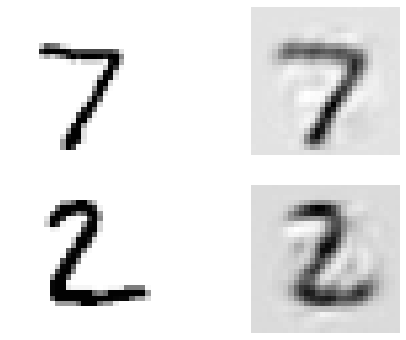

In [47]:
show_reconstructed_digits(X, outputs, "./saveModels/autoencoder_my_model_stacked_denoising_gaussian.ckpt")

> * 드롭아웃을 이용한 잡음제거 오토인코더

In [48]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [49]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [50]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [51]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./saveModels/autoencoder_my_model_stacked_denoising_dropout.ckpt")

0 Train MSE: 0.029438153
19% Train MSE: 0.02826005
29% Train MSE: 0.025354149
39% Train MSE: 0.025683537
49% Train MSE: 0.024914421
59% Train MSE: 0.024848042
69% Train MSE: 0.023544407
79% Train MSE: 0.024298154
89% Train MSE: 0.023144435
99% Train MSE: 0.022785317


INFO:tensorflow:Restoring parameters from ./saveModels/autoencoder_my_model_stacked_denoising_dropout.ckpt


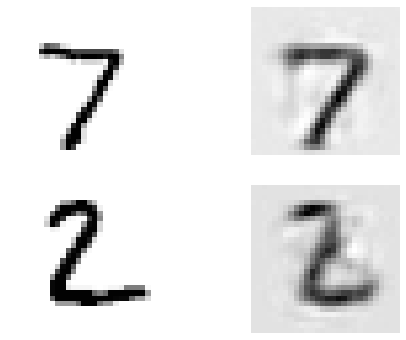

In [52]:
show_reconstructed_digits(X, outputs, "./saveModels/autoencoder_my_model_stacked_denoising_dropout.ckpt")

> * 가우시안 잡음과 드롭아웃을 이용한 오토인코더 학습

In [53]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [54]:
dropout_rate = 0.3
noise_level = 0.1

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))
X_drop = tf.layers.dropout(X_noisy, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE


In [55]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [56]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./saveModels/autoencoder_my_model_stacked_denoising_gaussian_dropout.ckpt")

09% Train MSE: 0.02643649
19% Train MSE: 0.02489832
29% Train MSE: 0.023921251
39% Train MSE: 0.023240399
49% Train MSE: 0.023135737
59% Train MSE: 0.022285106
69% Train MSE: 0.021343933
7 Train MSE: 0.0236756
89% Train MSE: 0.021492181
99% Train MSE: 0.022513427


INFO:tensorflow:Restoring parameters from ./saveModels/autoencoder_my_model_stacked_denoising_gaussian_dropout.ckpt


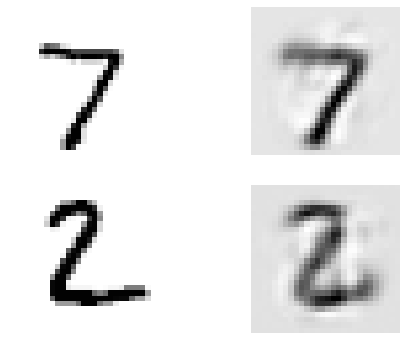

In [57]:
show_reconstructed_digits(X, outputs, "./saveModels/autoencoder_my_model_stacked_denoising_gaussian_dropout.ckpt")